### Pit Falls of basic embedding retreival
In this section we will cover some the challenges involved with retreival using embeddings of chunks for AI applications.

In [3]:
import chromadb
from chromadb.api.client import Client
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from pypdf import PdfReader


In [4]:
doc = PdfReader("MIV2 - LLM paper.pdf")
docs = [page.extract_text().strip() for page in doc.pages]

In [5]:
len(docs)

17

In [6]:
text_splits = []
text_splitter  = RecursiveCharacterTextSplitter(
    separators=["\n", "\n\n", "", " ", "."],
    chunk_size =1000,
    chunk_overlap = 200
)

In [7]:
character_text_splits = text_splitter.split_text("\n\n".join(docs))

In [8]:
len(character_text_splits)

68

In [9]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=256)

token_split_texts = []
for text in character_text_splits:
    token_split_texts += token_splitter.split_text(text)

/Users/kosisochukwuasuzu/Developer/ai-startups/test-demos/pdfchat/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/kosisochukwuasuzu/Developer/ai-startups/test-demos/pdfchat/venv/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [10]:
len(token_split_texts)

82

In [11]:
embedding_function = SentenceTransformerEmbeddingFunction()

In [13]:
client = Client()
collection = client.create_collection(name="research_paper", embedding_function=embedding_function)

In [14]:
ids = [str(i) for i in range(len(token_split_texts))]

In [15]:
collection.add(ids=ids, documents=token_split_texts)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [16]:
collection.count()

82

In [17]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = collection.get(include=['embeddings'])['embeddings']

In [19]:
len(embeddings[0])

384

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embedding_pca_func = pca.fit(embeddings)


In [22]:
def project_embeddings(embeddings, embedding_pca_func):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = embedding_pca_func.transform([embedding])
    return umap_embeddings   

In [23]:
projected_dataset_embeddings = project_embeddings(embeddings, embedding_pca_func)

100%|██████████| 82/82 [00:00<00:00, 11964.13it/s]


In [25]:
len(projected_dataset_embeddings[0])

2

(-0.4443726856240486,
 0.8054211447550191,
 -0.3921210699098899,
 0.6763395972792635)

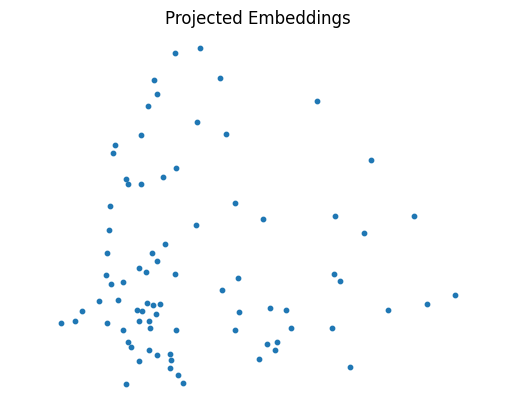

In [26]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10)
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off')

##### Relevancy Distraction

In [27]:
from pprint import pprint

In [28]:
query = "What is the total revenue?"

results = collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    pprint(document)
    print('')

('ca, s., costa, e., castellucci, i. and arezes, p. m., 2019. a brief overview '
 'of the use of')

('for the llm prompt, thereby enabling the integration of object affordances '
 'into the llm ’ s plan generation. figure 2 : continuous feedback process '
 'between human user and llm to generate robot plan. the human provides '
 'feedback instructions in natural language which the llm uses to update the '
 'generated plan 2. 2 perception with foundation vision models. as part of the '
 'set of robot skills, perception actions are defined, incorporating '
 'foundational vision models for zero - shot object detection and scene '
 'understanding. the vision models are employed for object identification '
 'within the scene, yielding bounding boxes for detected objects. '
 'subsequently, pixel - to - coordinate values are computed. the perception '
 'functions operate beneath the rule - based actions, albeit not directly '
 'presented as skills to the llm. full object generalisation is pos

In [29]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], embedding_pca_func)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, embedding_pca_func)


100%|██████████| 5/5 [00:00<00:00, 9161.87it/s]


(-0.4443726856240486,
 0.8054211447550191,
 -0.3921210699098899,
 0.6763395972792635)

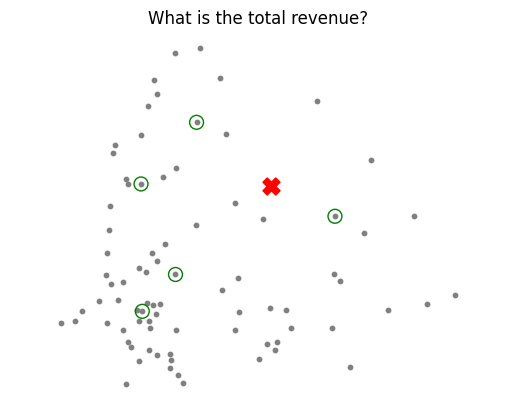

In [30]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [31]:
query = "What is the strategy around artificial intelligence (AI) ?"
results = collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    pprint(document)
    print('')

('vey of its applications, challenges, limitations, and future prospects. '
 'techrxiv. preprint. https : / / doi. org / 10. 36227 / techrxiv. 23589741. '
 'v3 [ 16 ] yao, s., zhao, j., yu, d., du, n., shafran, i., narasimhan, k. and '
 'cao, y., 2022. react : synergizing reasoning and acting in language models. '
 'arxiv preprint arxiv : 2210. 03629. [ 17 ] lykov, a. and tsetserukou, d., '
 '2023. llm - brain : ai - driven fast generation of robot behaviour tree '
 'based on large language model. arxiv preprint arxiv : 2305. 19352. [ 18 ] '
 'ding, y., zhang, x., amiri, s., cao, n., yang, h., esselink, c. and zhang, '
 's., 2022. robot task planning and situation handling in open worlds. arxiv '
 'preprint arxiv : 2210. 01287. [ 19')

('mance increase in simulated evaluations and a 14 % increase in physical '
 'evaluations compared to the baseline, showcasing the efficacy of the '
 'proposed approach. keywords : human - robot interaction, robotics, robot - '
 'arm, large language mode

In [32]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], embedding_pca_func)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, embedding_pca_func)


100%|██████████| 5/5 [00:00<00:00, 9258.95it/s]


(-0.4443726856240486,
 0.8054211447550191,
 -0.3921210699098899,
 0.6763395972792635)

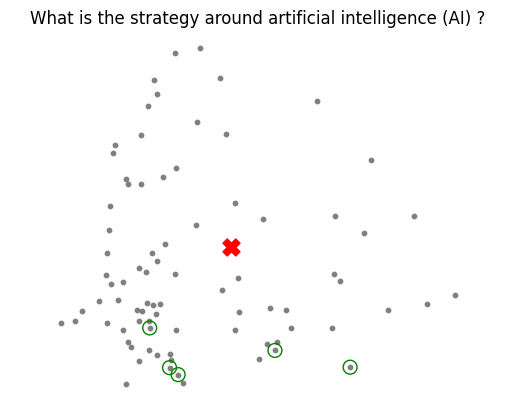

In [33]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [34]:
query = "What has been the investment in research and development?"
results = collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    pprint(document)
    print('')

('ca, s., costa, e., castellucci, i. and arezes, p. m., 2019. a brief overview '
 'of the use of')

('] yu, w., gileadi, n., fu, c., kirmani, s., lee, k. h., arenas, m. g., '
 'chiang, h. t. l., erez, t., hasenclever, l., humplik, j. and ichter, b., '
 '2023. language to rewards for robotic skill synthesis. arxiv preprint arxiv '
 ': 2306. 08647. [ 20 ] jiang, y., gupta, a., zhang, z., wang, g., dou, y., '
 'chen, y., fei - fei, l., anandkumar, a.,')

('ing that llms not only provide a policy for action but also offer a '
 'commonsense model of the world [ 45 ]. monte carlo tree search, a powerful '
 'search algorithm, was employed in this exploration. this involved '
 'integrating the world model into the policy for a search algorithm like '
 'mcts. concurrently, llms with tree - of - thought ( llm - tot ) approach '
 'adopted a tree - based strategy, enabling llms to engage in deliberate '
 'decision - making by assessing various reasoning paths and self - evaluating '
 'choices to d

In [36]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], embedding_pca_func)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, embedding_pca_func)


100%|██████████| 5/5 [00:00<00:00, 6923.58it/s]


(-0.4443726856240486,
 0.8054211447550191,
 -0.3921210699098899,
 0.6763395972792635)

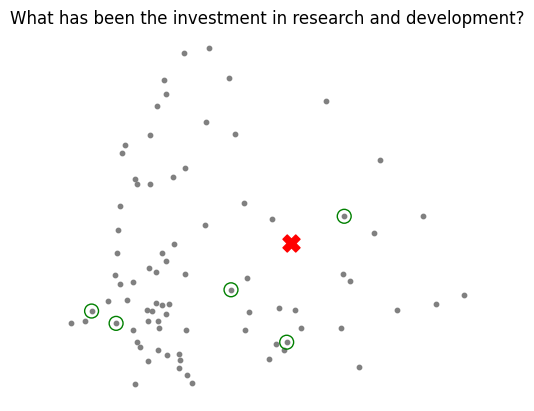

In [37]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [38]:
query = "What has Michael Jordan done for us lately?"
results = collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    pprint(document)
    print('')

('– 63. doi : https : / / doi. org / 10. 1109 / mra. 2014. 2369292. 15 [ 32 ] '
 'vaswani, a., shazeer, n., parmar, n., uszkoreit, j., jones, l., gomez, a. '
 'n., kaiser, l. and')

('highlights key approaches in the realm of zero - shot learning and '
 'detection, providing a foundation for the current research. 1. 1. 5 llms for '
 'robot planning the integration of llms with robotics has opened new '
 'frontiers in robot planning and execution [ 17 ]. these models empower '
 'robots with natural language understanding, enabling them to interact with '
 'humans and external systems through text or speech [ 10 ]. one of the '
 'foundational applications of llms in robotics is the understanding of '
 'natural lan - guage commands [ 4 ] [ 9 ]. research in this area has explored '
 'methods for mapping text or spoken language into executable robot commands [ '
 '1 ]. seminal works by brohan et al. and jiang et al. have demonstrated the '
 'feasibility of converting human instructions into

In [39]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], embedding_pca_func)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, embedding_pca_func)


100%|██████████| 5/5 [00:00<00:00, 9086.45it/s]


(-0.4443726856240486,
 0.8054211447550191,
 -0.3921210699098899,
 0.6763395972792635)

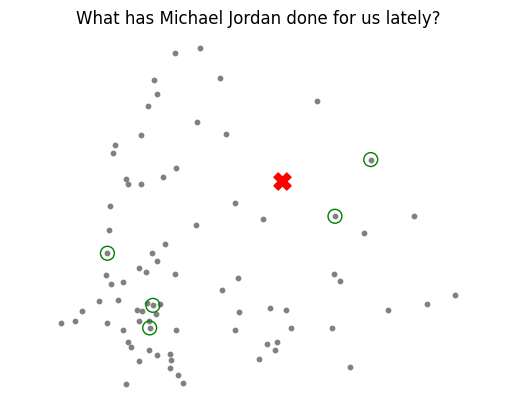

In [40]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')

In [41]:
query = "What robot arm was used in the experiment?"
results = collection.query(query_texts=query, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents'][0]

for document in results['documents'][0]:
    pprint(document)
    print('')

('https : / / www. intelrealsense. com / depth - camera - d435i /. [ 52 ] w. '
 'a. bainbridge, j. hart, e. s. kim and b. scassellati, ” the effect of '
 'presence on human - robot interaction, ” ro - man 2008 - the 17th ieee '
 'international symposium on robot and human interactive communication, '
 'munich, germany, 2008, pp. 701 - 706, doi : 10. 1109 / ro - man. 2008. '
 '4600749. [ 53 ] a. vick, d. surdilovic and j. kr¨ uger, ” safe physical '
 'human - robot interaction with industrial dual - arm robots, ” 9th '
 'international workshop on robot motion and control, kuslin, poland, 2013, '
 'pp. 264 - 269, doi : 10. 1109 / romoco. 2013. 6614619. [ 54 ] [UNK] ca, s., '
 'costa, e., castellucci, i. and arezes, p. m., 2019. a brief overview of the '
 'use of collaborative robots in industry 4. 0 : human role and safety. '
 'occupational and environmental safety and health, pp. 641 - 650. [ 55 ] '
 '[UNK]')

('to the simulated environment, as depicted in figure 5, incorporating a top 

In [42]:
query_embedding = embedding_function([query])[0]
retrieved_embeddings = results['embeddings'][0]

projected_query_embedding = project_embeddings([query_embedding], embedding_pca_func)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, embedding_pca_func)

100%|██████████| 5/5 [00:00<00:00, 6009.03it/s]


(-0.4443726856240486,
 0.8054211447550191,
 -0.3921210699098899,
 0.6763395972792635)

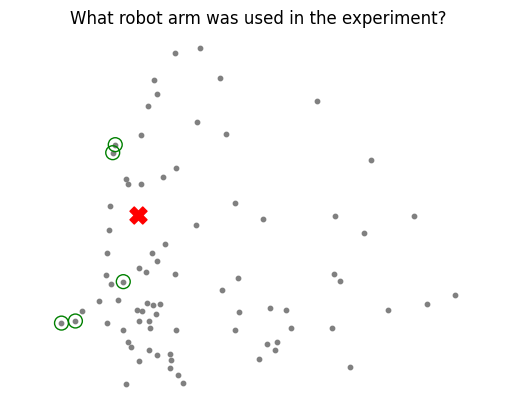

In [43]:
# Plot the projected query and retrieved documents in the embedding space
plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_query_embedding[:, 0], projected_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{query}')
plt.axis('off')